In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
extract = zipfile.ZipFile('/content/drive/MyDrive/Plant_leaf_diseases_dataset_with_augmentation.zip')
extract.extractall()

In [3]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from datetime import datetime

# Define the directory containing your image files
root_dir = '/content/Plant_leave_diseases_dataset_with_augmentation/'

# Initialize lists to store image data and file paths
file_paths = []

# Traverse through the root directory and its subdirectories
for subdir, dirs, files in os.walk(root_dir):
    # Iterate over files in the current directory
    for file in files:
        # Check if the file ends with '.JPG'
        if file.endswith('.JPG'):
            # Append the file path to the list
            file_paths.append(os.path.join(subdir, file))

# Create a DataFrame to store the file paths
image_df = pd.DataFrame({'file_path': file_paths})

# Define indices for train, validation, and test sets
indices = list(range(len(image_df)))
np.random.shuffle(indices)
split = int(np.floor(0.85 * len(image_df)))
validation = int(np.floor(0.70 * split))
train_indices, validation_indices, test_indices = (
    indices[:validation],
    indices[validation:split],
    indices[split:],
)

# Define transformations
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = {folder_name: i for i, folder_name in enumerate(sorted(set(self.dataframe['file_path'].apply(lambda x: x.split(os.path.sep)[-2]))))}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['file_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        # Extract class index from the file path
        label = self.class_to_idx[img_path.split(os.path.sep)[-2]]  # Use the class_to_idx dictionary
        return image, label


# Create dataset instances
train_dataset = CustomDataset(image_df.iloc[train_indices], transform=transform)
validation_dataset = CustomDataset(image_df.iloc[validation_indices], transform=transform)
test_dataset = CustomDataset(image_df.iloc[test_indices], transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            # conv2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            # conv3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            # conv4
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(50176, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, K),
        )

    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0), -1)  # Flatten
        out = self.dense_layers(out)
        return out

# Initialize the model
targets_size = 39  # Assuming you have 39 classes
model = CNN(targets_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Function for batch gradient descent
def batch_gd(model, criterion, train_loader, validation_loader, epochs):
    train_losses = []
    validation_losses = []

    for e in range(epochs):
        t0 = datetime.now()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = criterion(outputs, targets)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss for the epoch
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validate the model
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for inputs, targets in validation_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                # Forward pass
                outputs = model(inputs)
                # Compute loss
                loss = criterion(outputs, targets)
                validation_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss for the epoch
        validation_loss /= len(validation_loader.dataset)
        validation_losses.append(validation_loss)

        # Print training progress
        print(f"Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Time: {datetime.now() - t0}")

    return train_losses, validation_losses


# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Call the batch_gd function
train_losses, validation_losses = batch_gd(
    model, criterion, train_loader, validation_loader, 5
)


Epoch 1/5, Train Loss: 2.2669, Validation Loss: 1.2480, Time: 0:05:28.583393
Epoch 2/5, Train Loss: 0.9446, Validation Loss: 0.7949, Time: 0:05:21.385319
Epoch 3/5, Train Loss: 0.6212, Validation Loss: 0.6127, Time: 0:05:21.013361
Epoch 4/5, Train Loss: 0.4730, Validation Loss: 0.5843, Time: 0:05:20.833146
Epoch 5/5, Train Loss: 0.3865, Validation Loss: 0.5778, Time: 0:05:21.287509


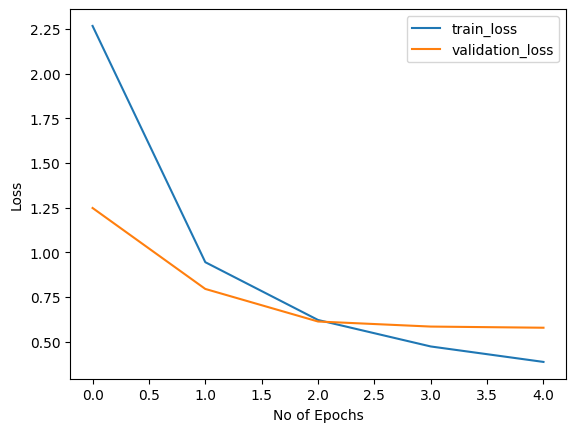

In [4]:
import matplotlib.pyplot as plt

plt.plot(train_losses , label = 'train_loss')
plt.plot(validation_losses , label = 'validation_loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [5]:
def accuracy(loader):
    n_correct = 0
    n_total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

    acc = n_correct / n_total
    return acc

In [6]:
train_acc = accuracy(train_loader)
test_acc = accuracy(test_loader)
validation_acc = accuracy(validation_loader)

In [7]:
print(
    f"Train Accuracy : {train_acc}\nTest Accuracy : {test_acc}\nValidation Accuracy : {validation_acc}"
)

Train Accuracy : 0.9006291106662854
Test Accuracy : 0.847340365203584
Validation Accuracy : 0.8604883907125701


These additional EDA steps provide deeper insights into image characteristics, color distributions, and preprocessing effects, which can be valuable for both understanding your dataset and optimizing your image preprocessing pipeline and model architecture.

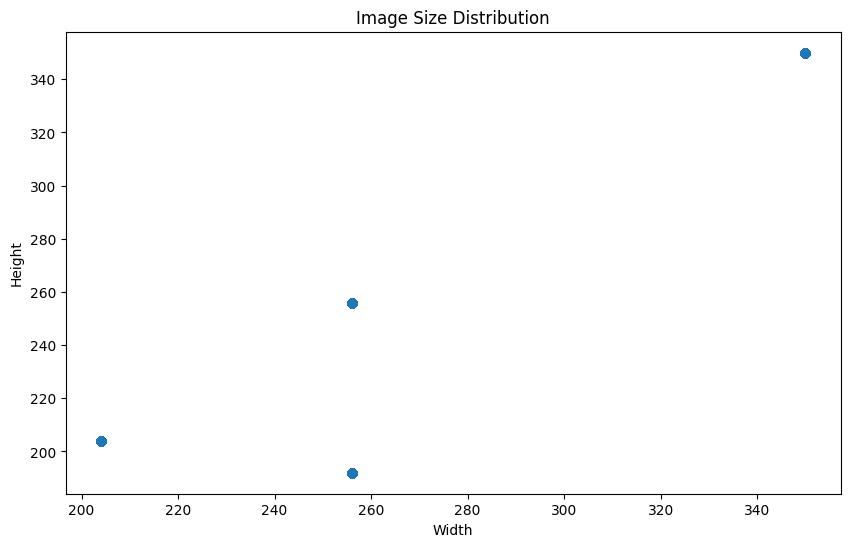

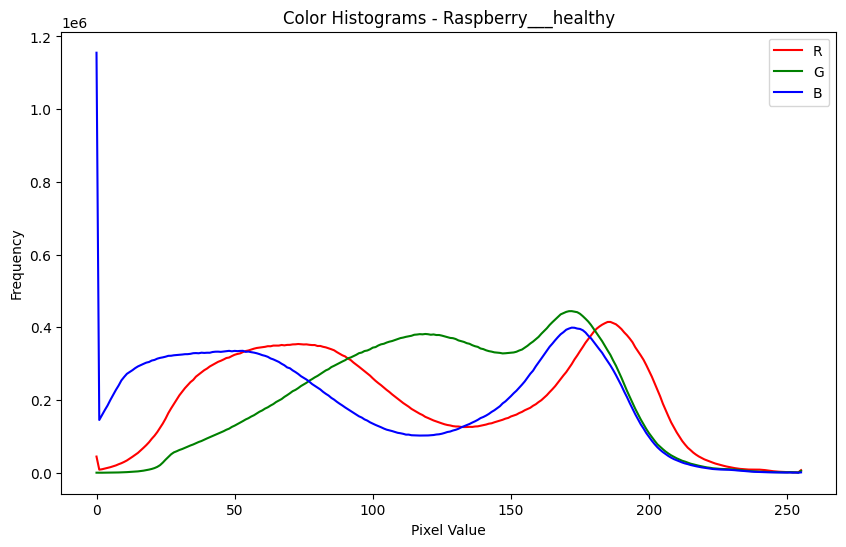

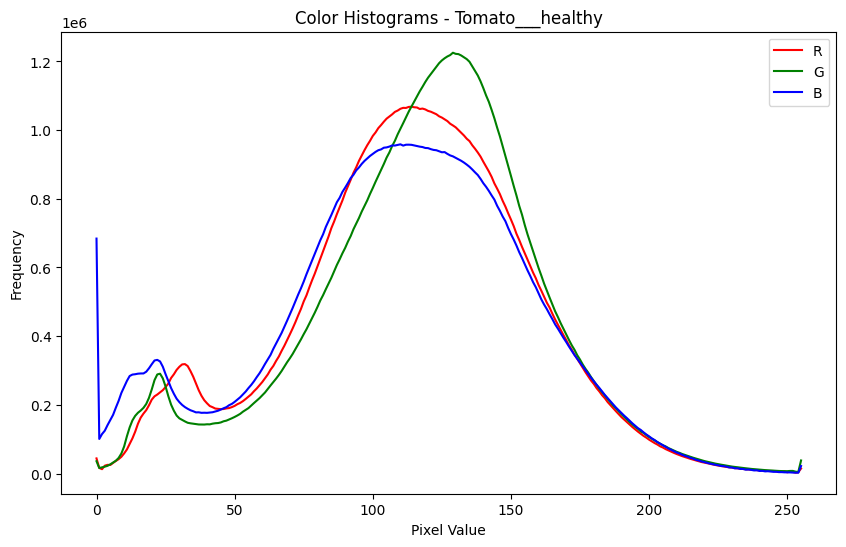

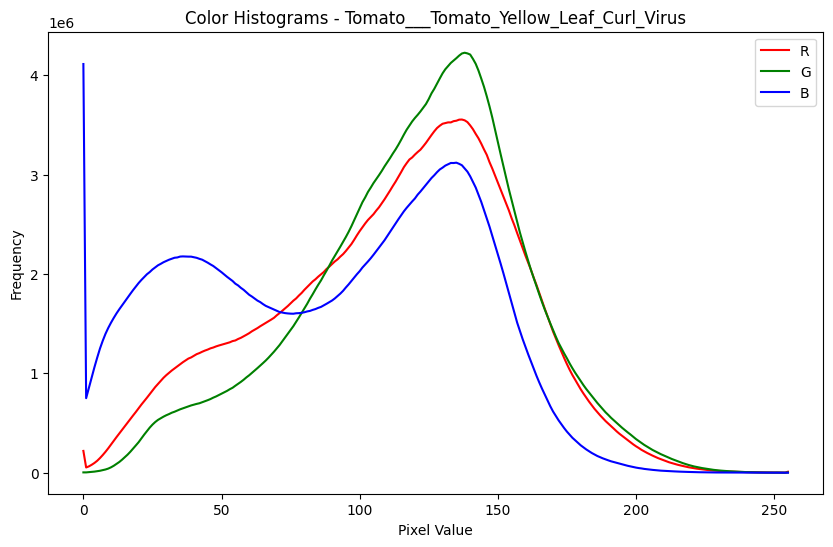

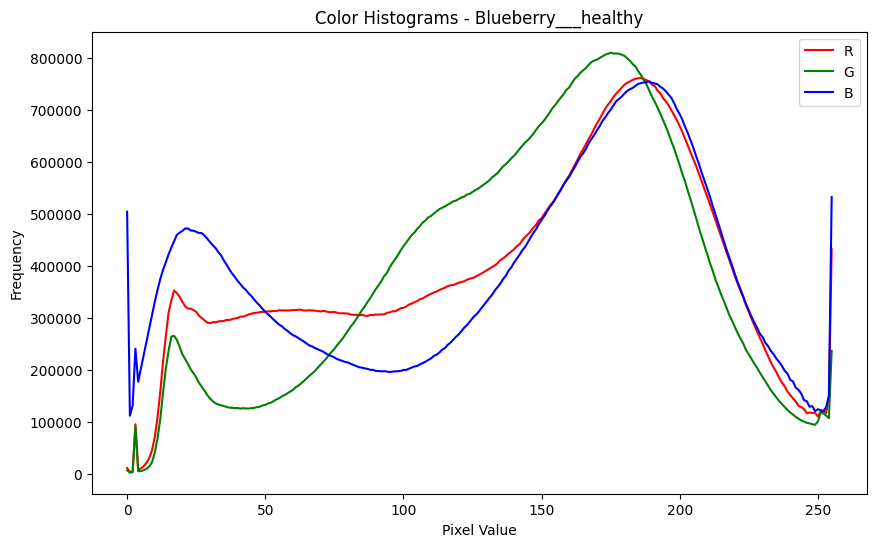

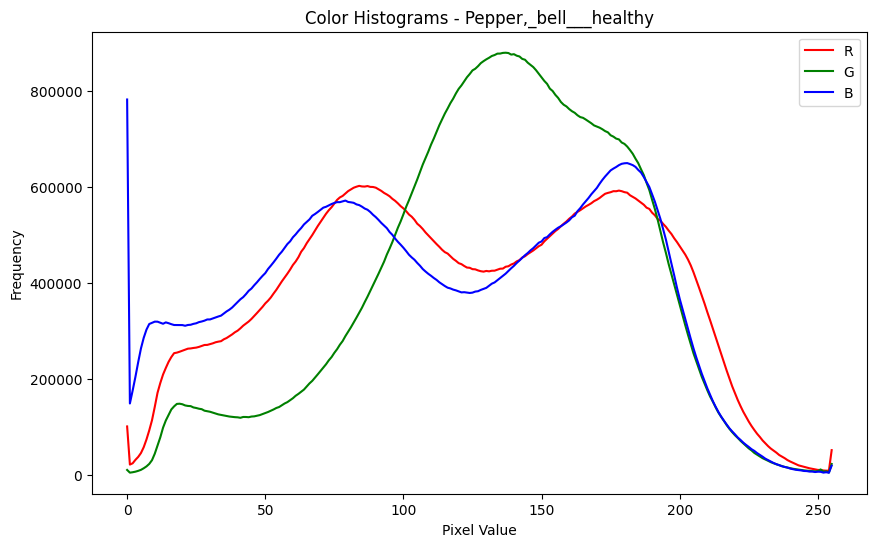

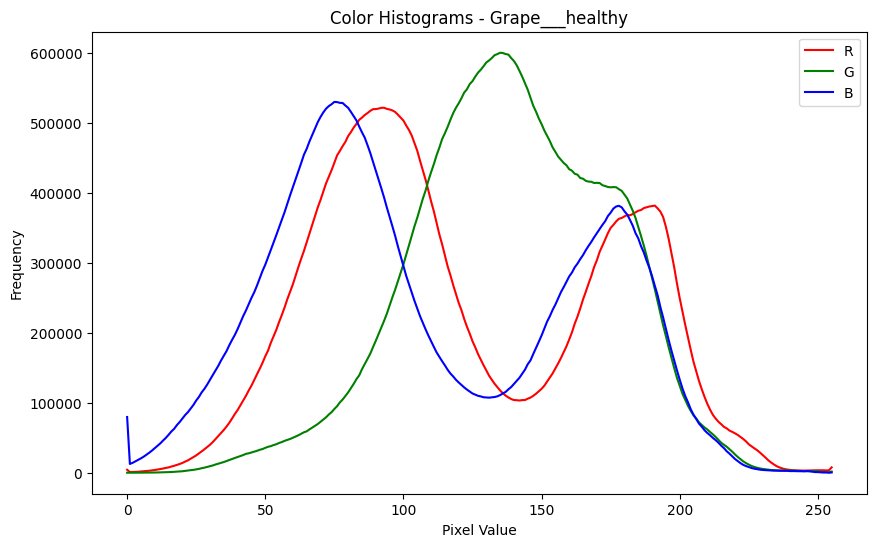

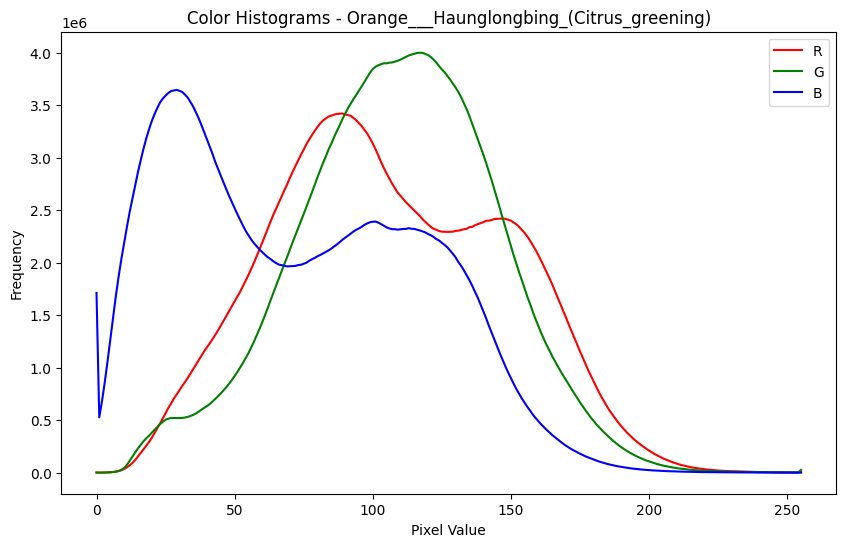

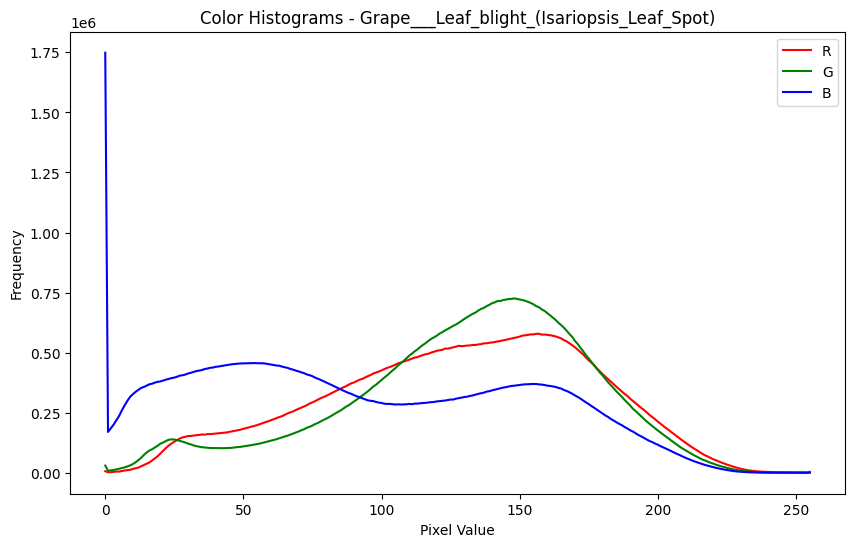

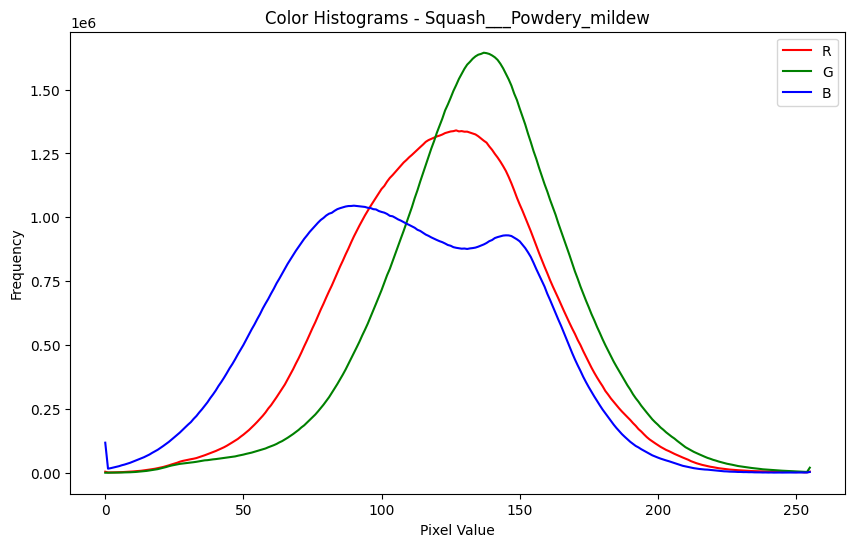

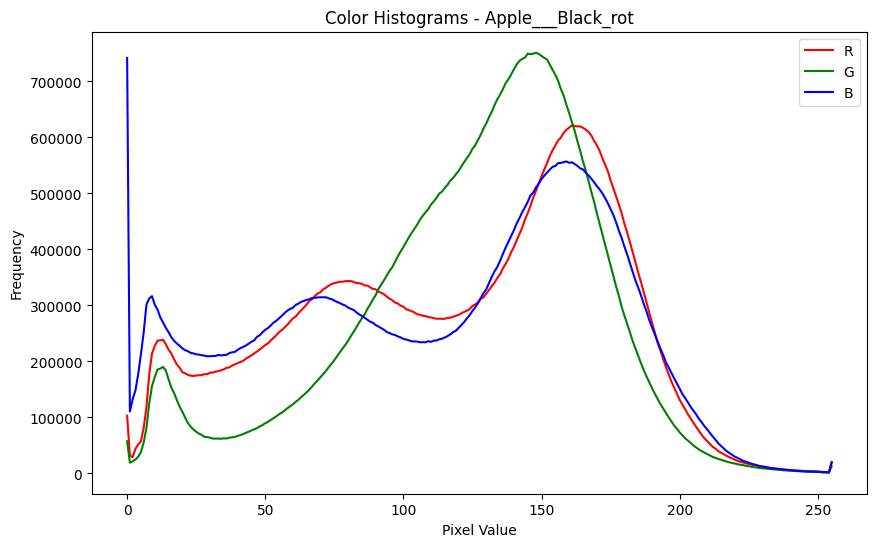

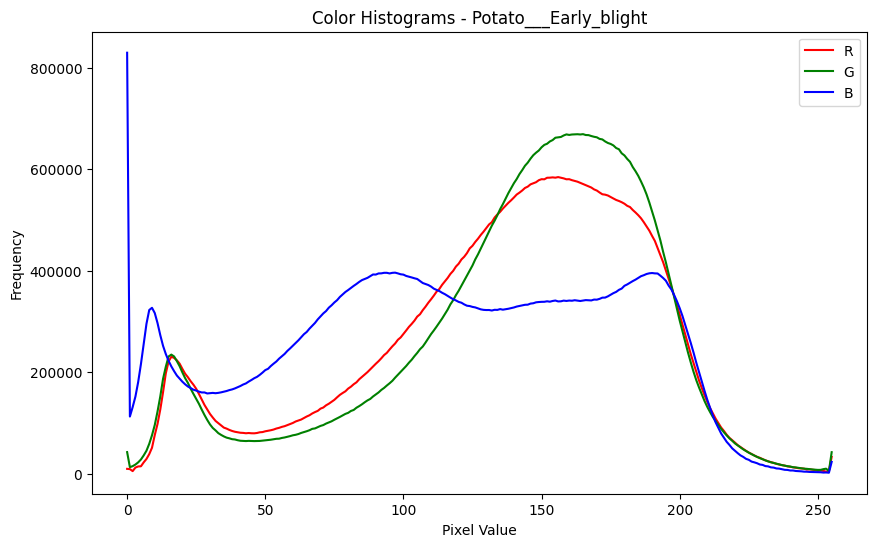

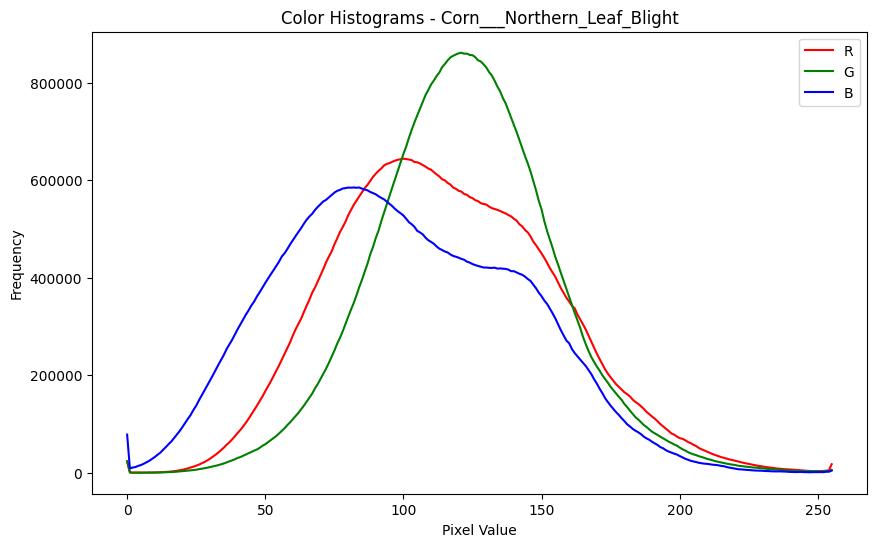

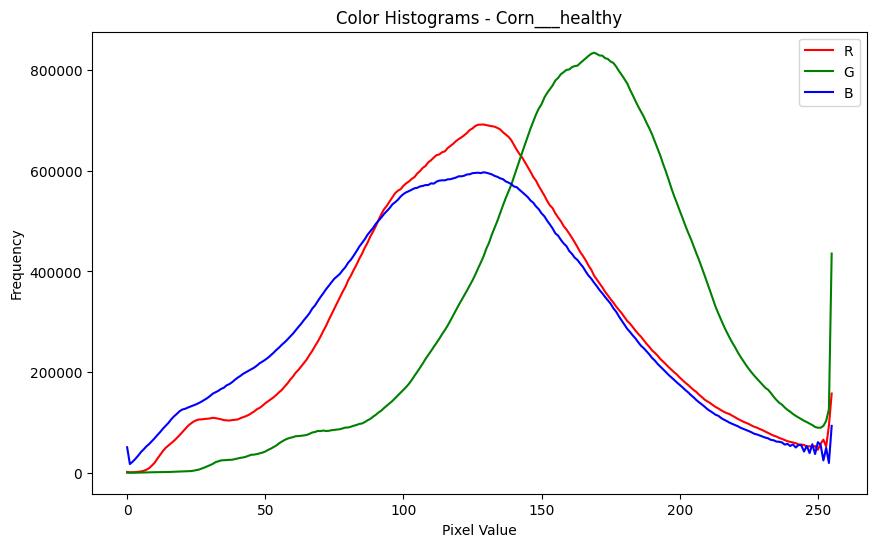

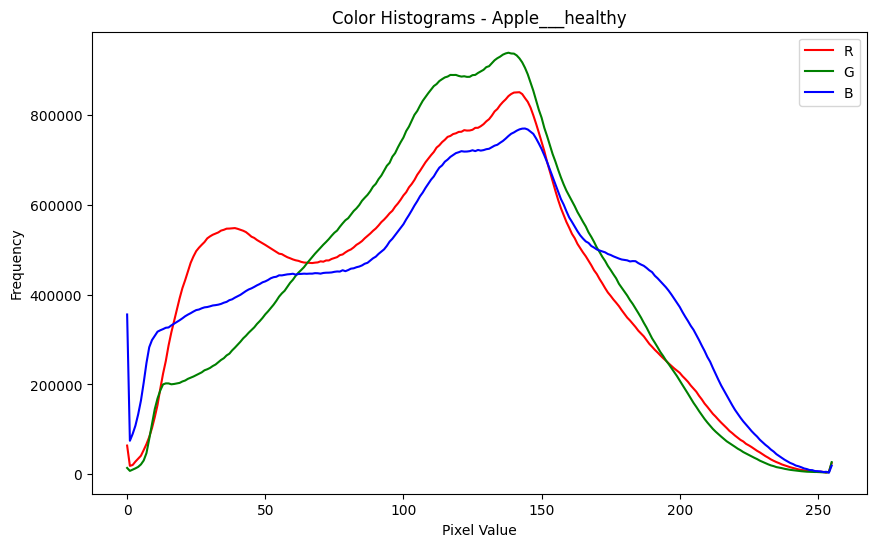

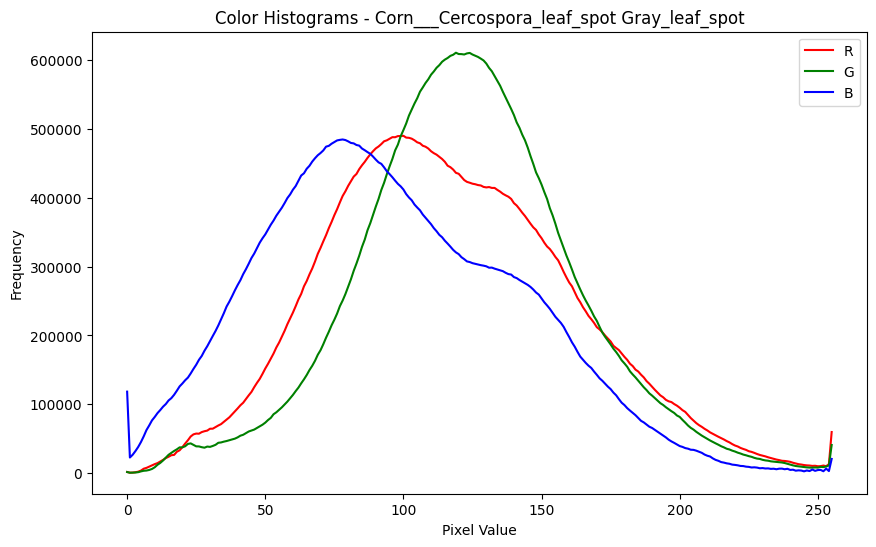

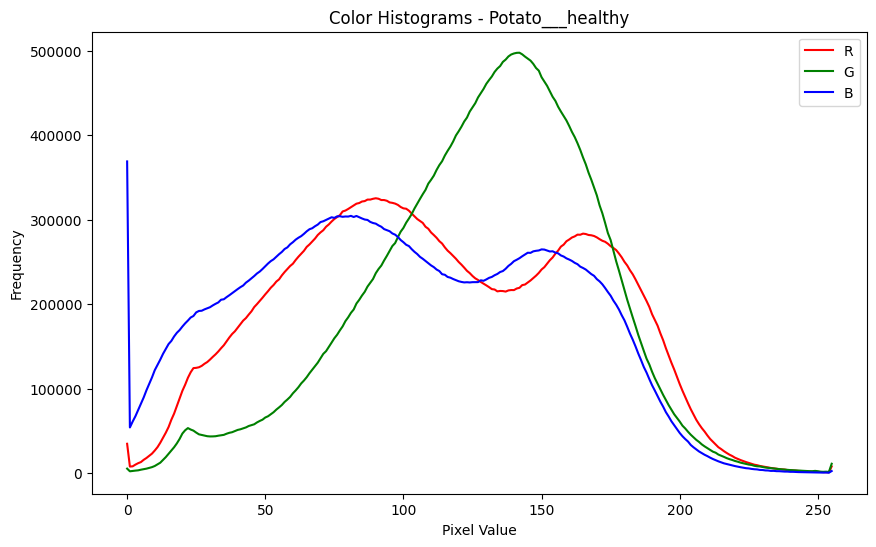

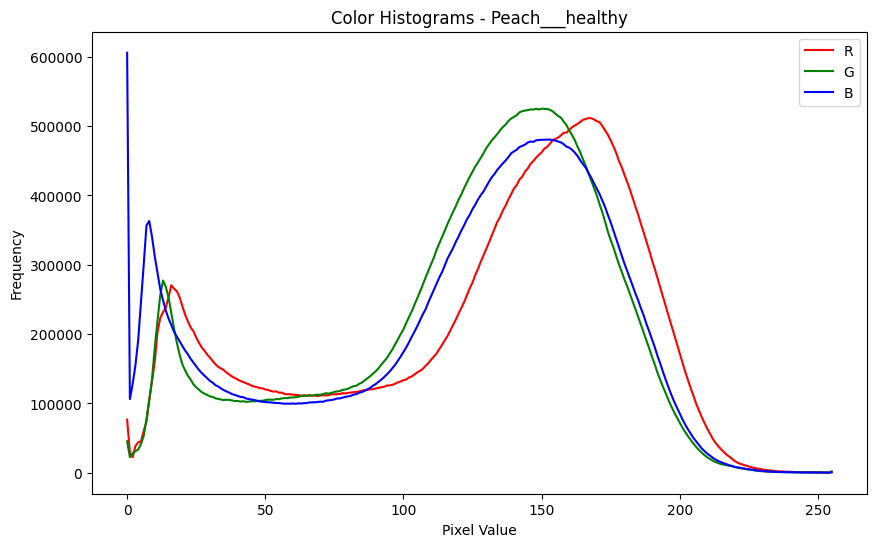

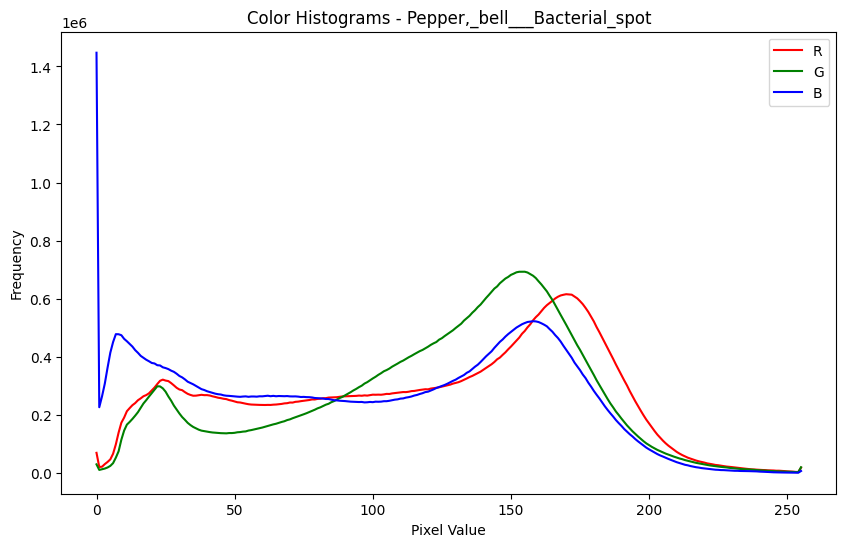

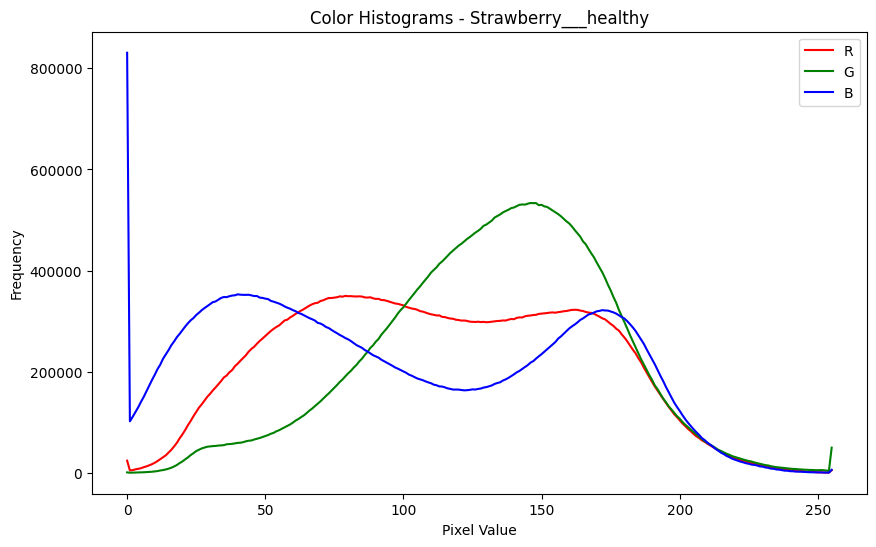

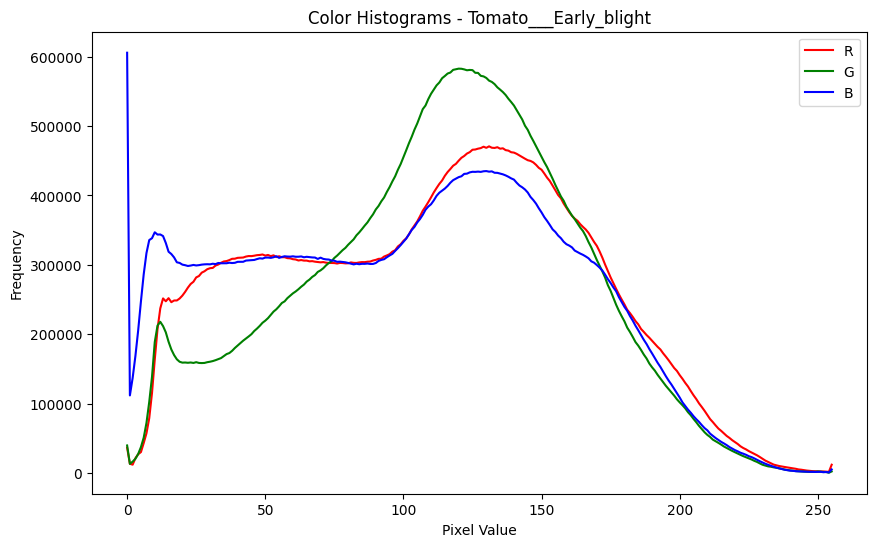

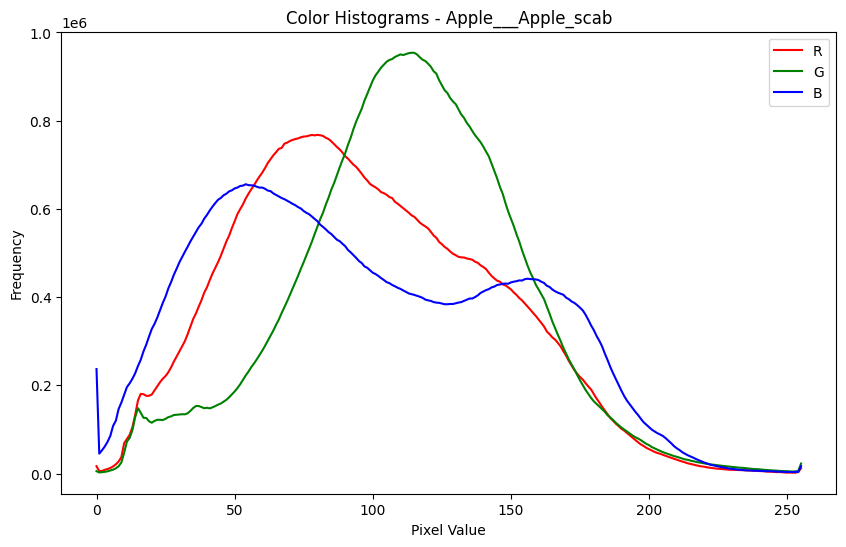

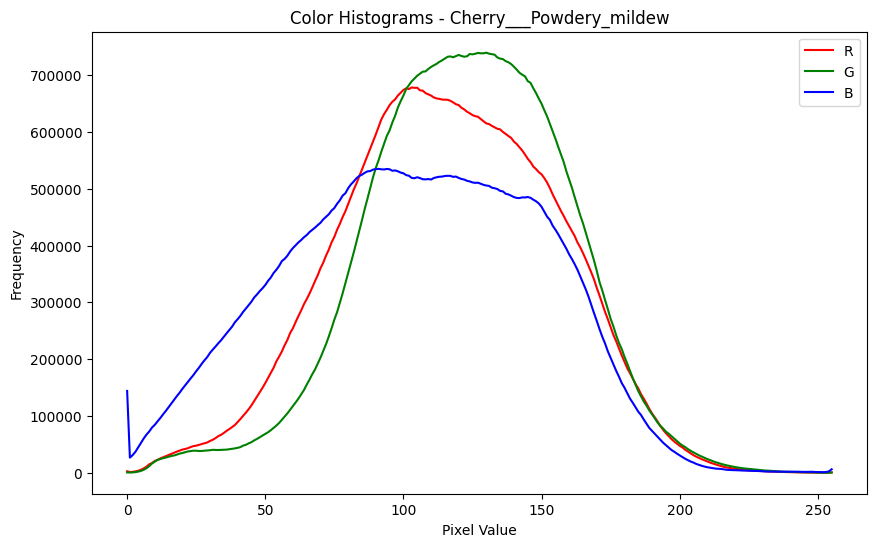

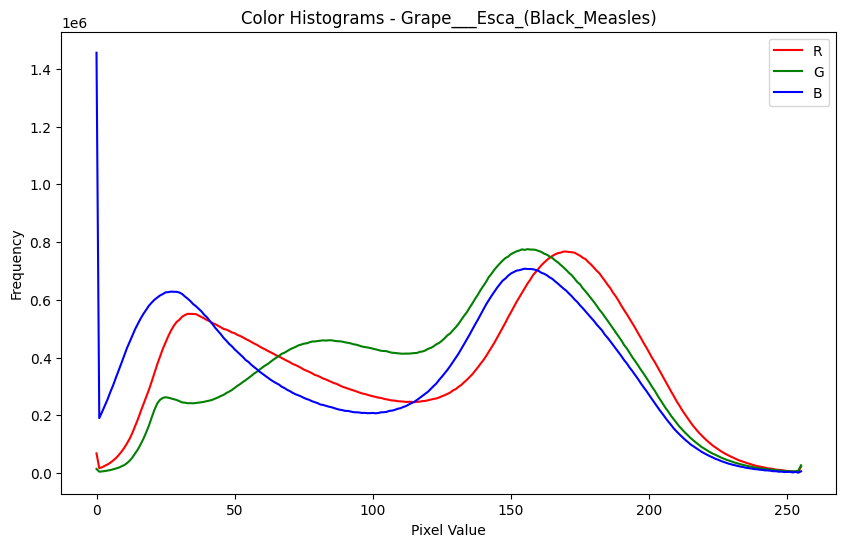

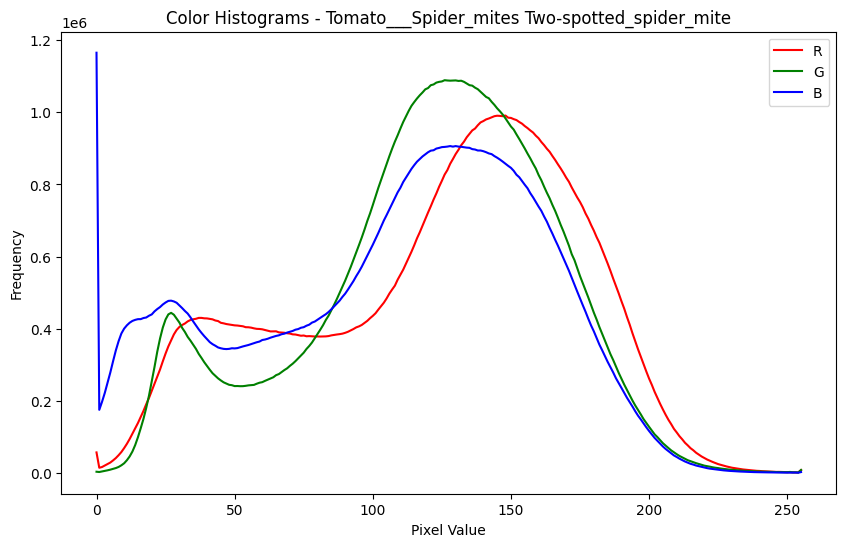

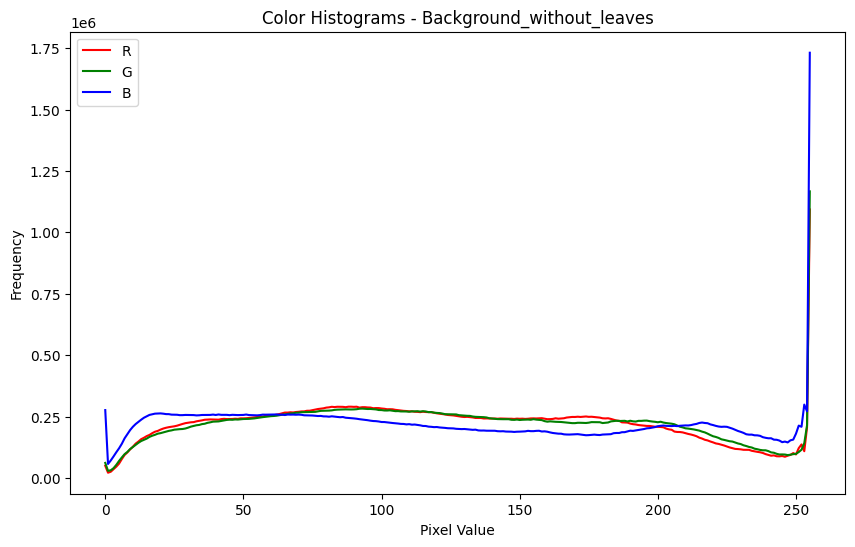

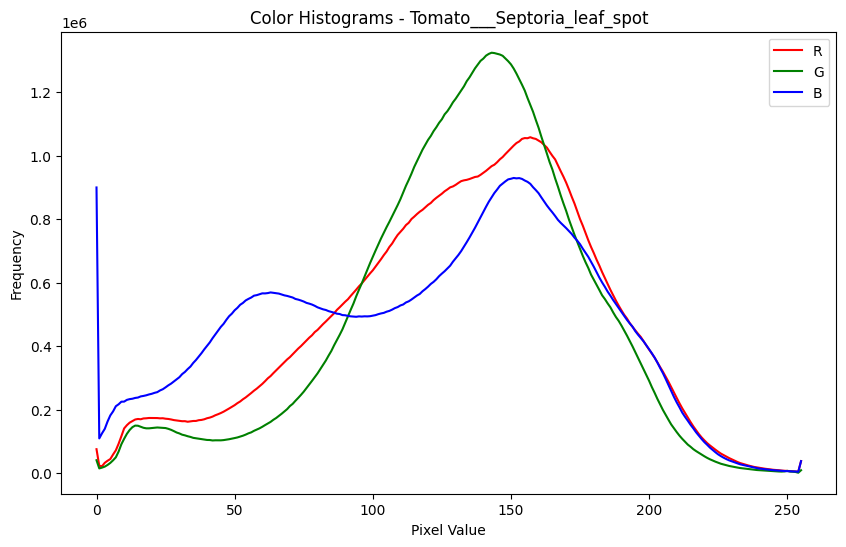

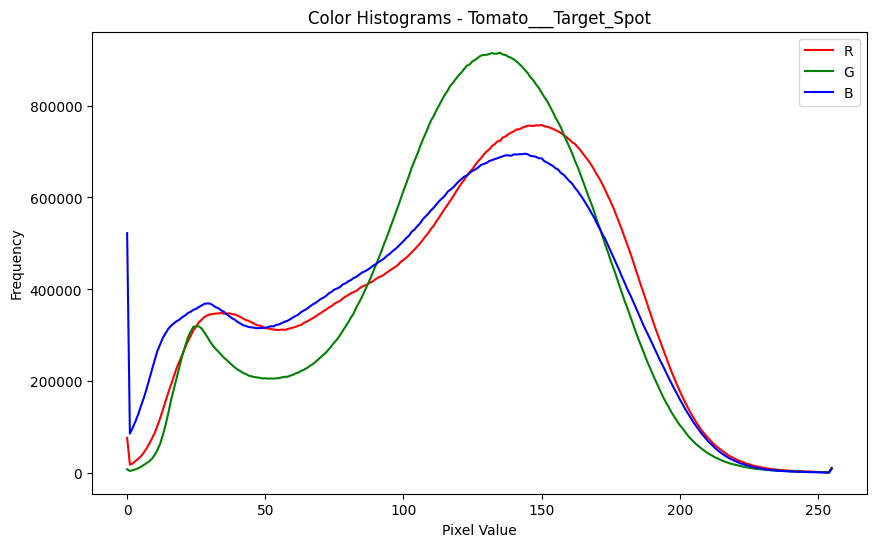

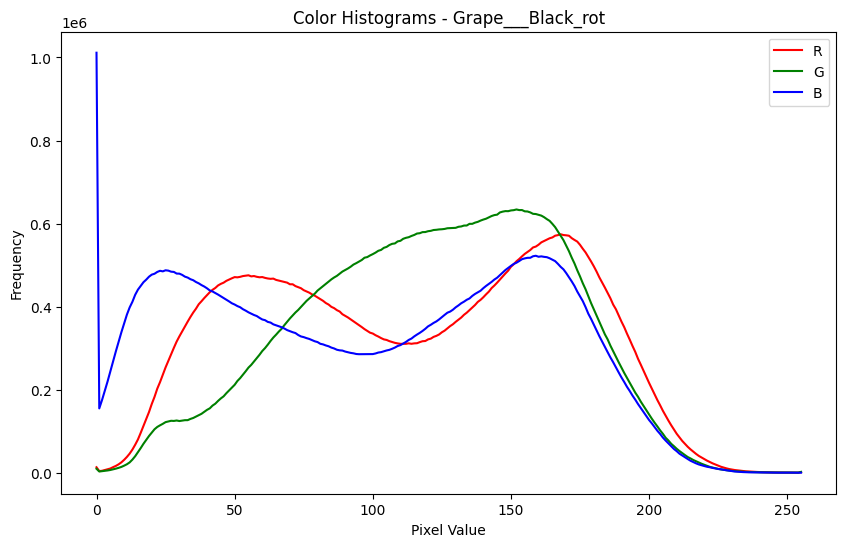

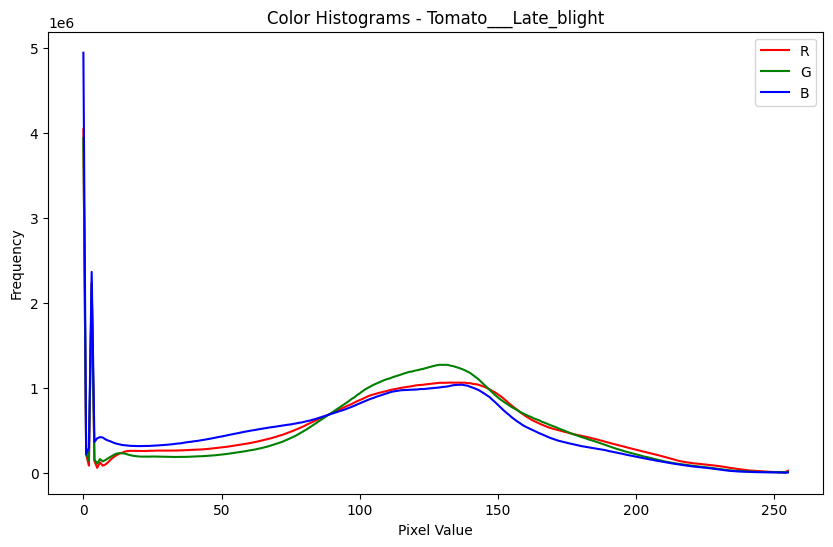

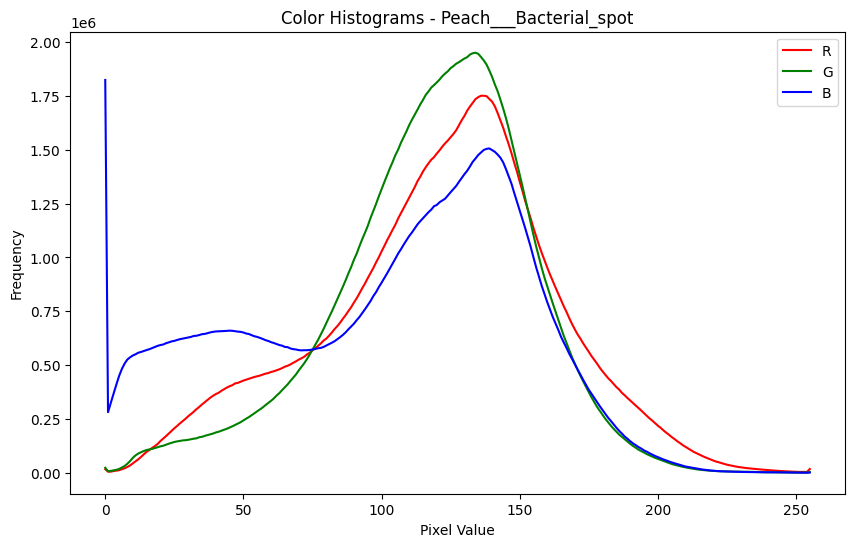

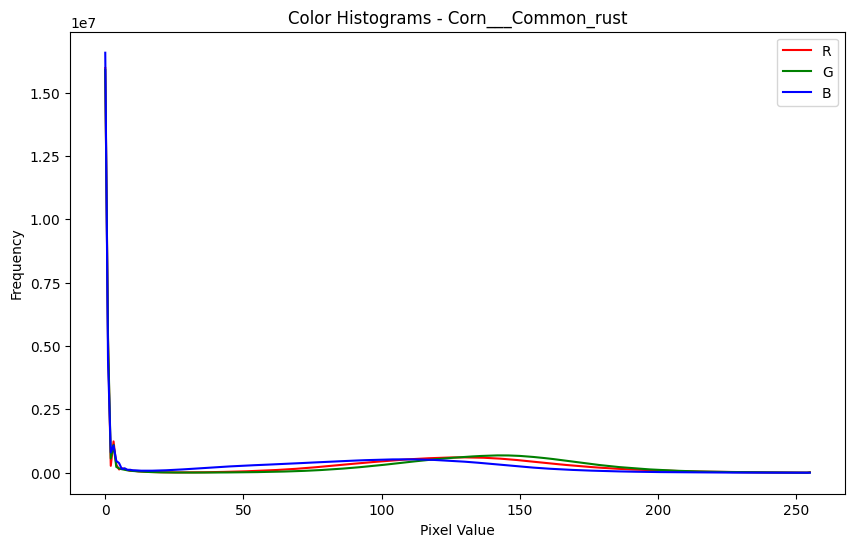

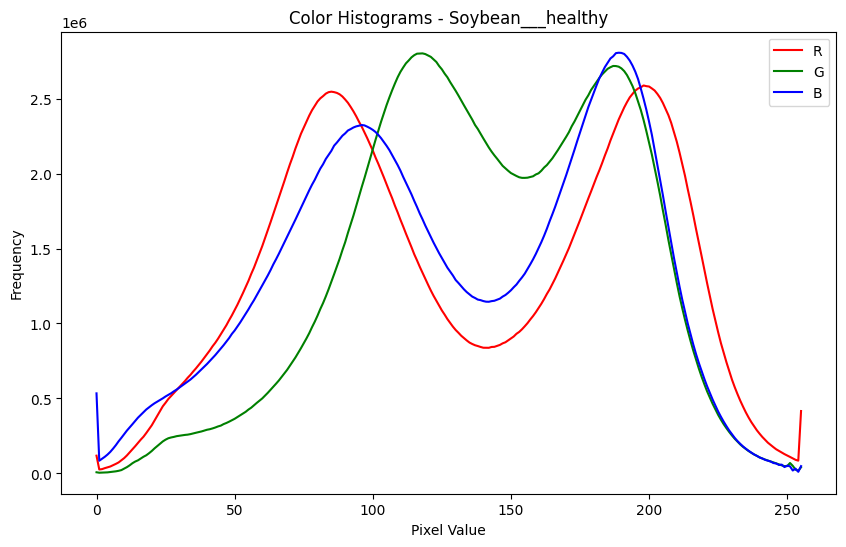

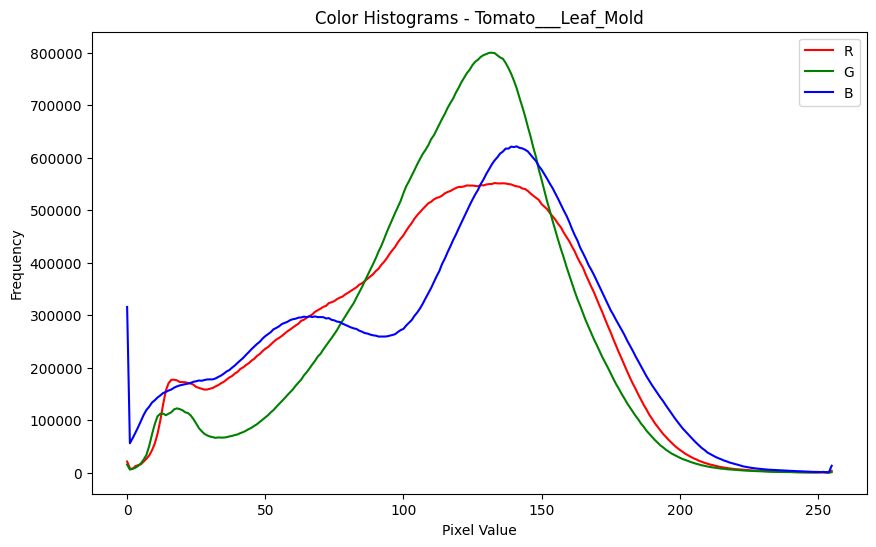

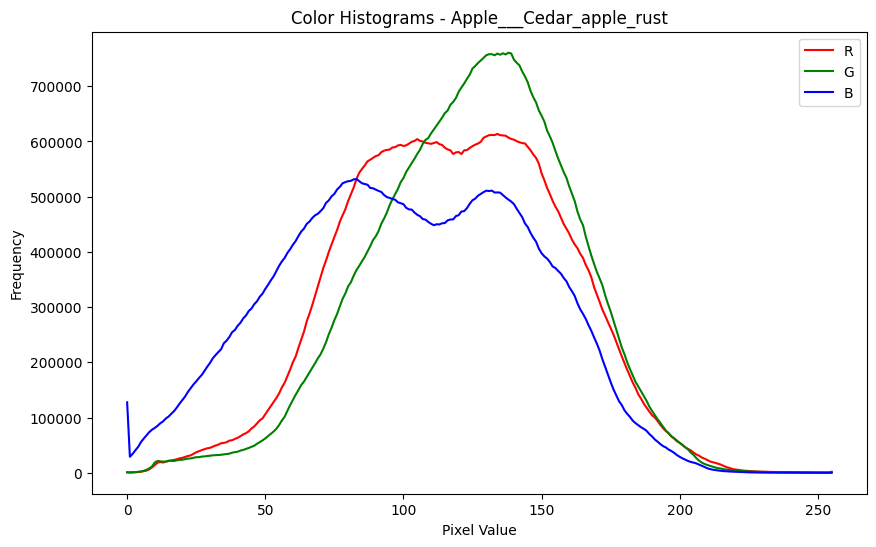

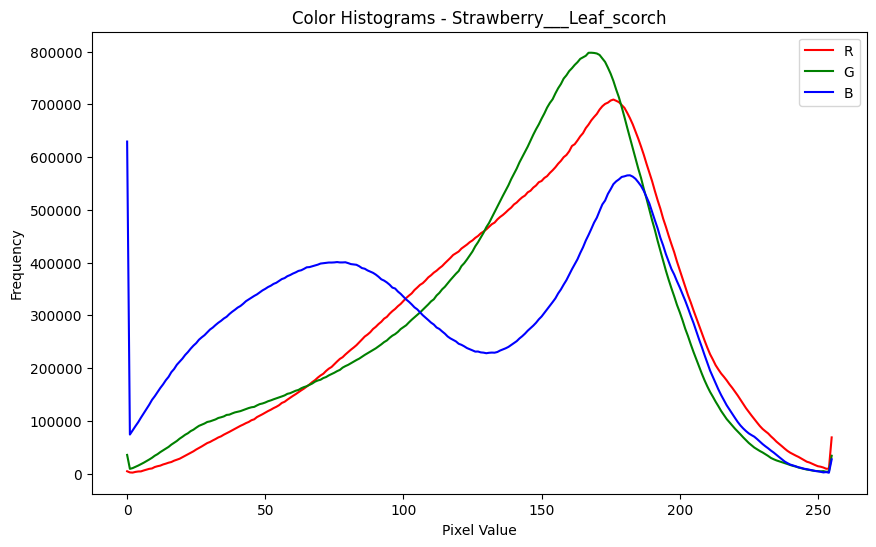

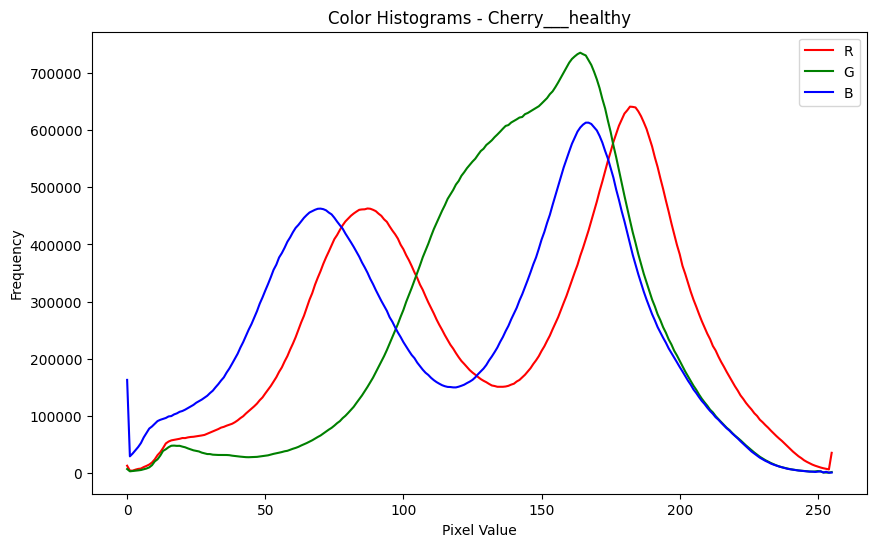

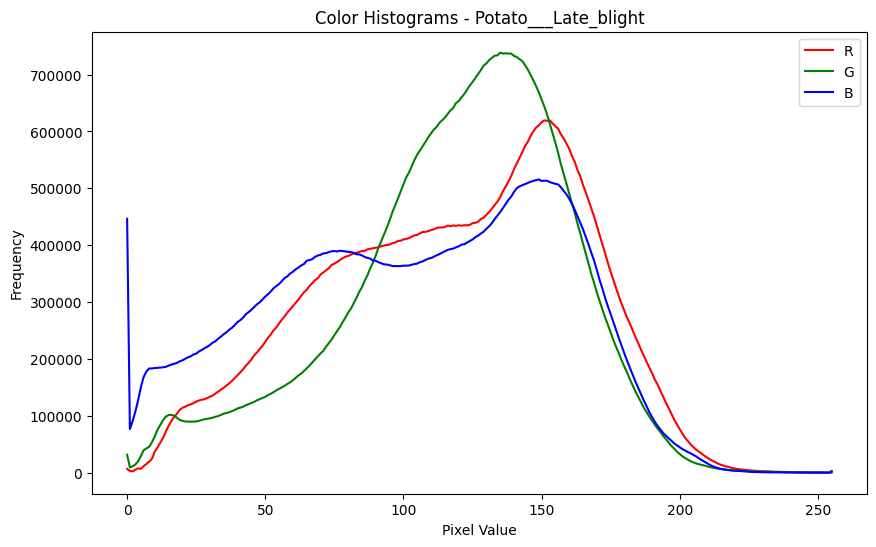

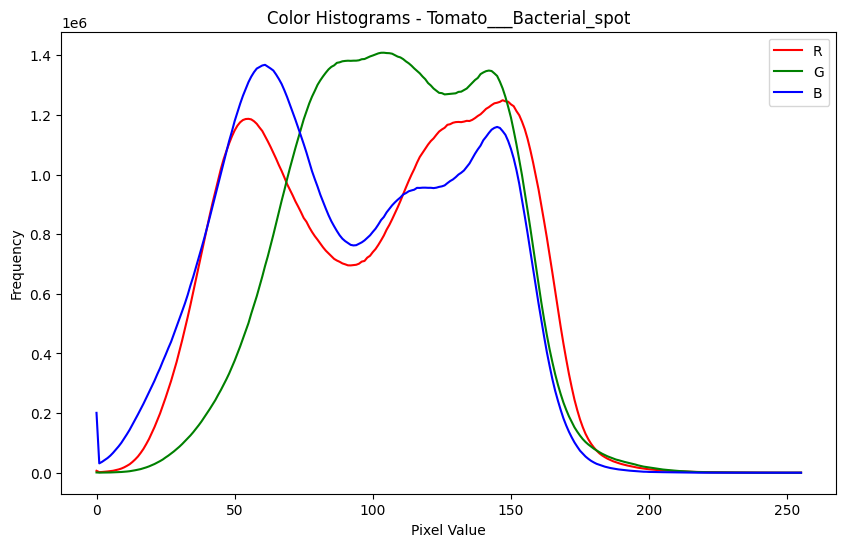

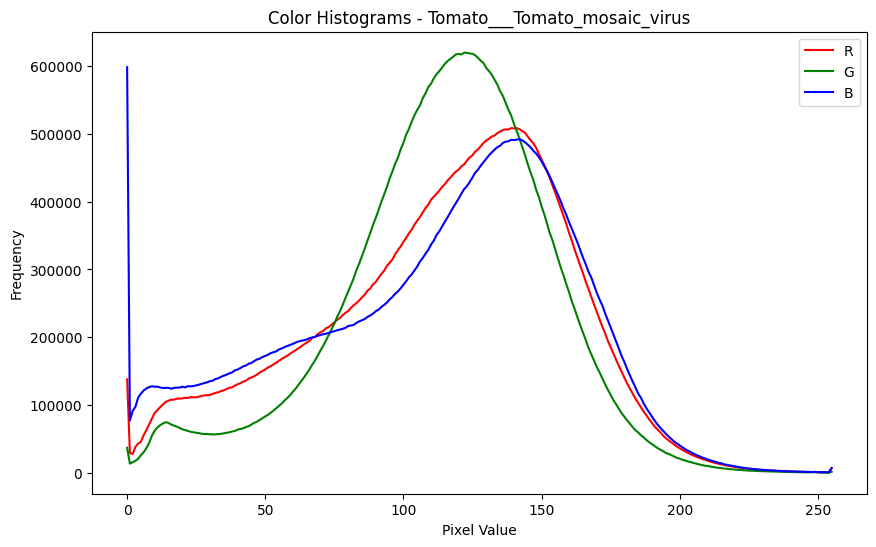

In [9]:
# Function to plot image size distribution
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
def plot_image_size_distribution(root_dir):
    classes = os.listdir(root_dir)
    image_sizes = []

    for cls in classes:
        class_dir = os.path.join(root_dir, cls)
        images = os.listdir(class_dir)
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            height, width, _ = img.shape
            image_sizes.append((height, width))

    image_sizes = np.array(image_sizes)
    plt.figure(figsize=(10, 6))
    plt.scatter(image_sizes[:, 1], image_sizes[:, 0], alpha=0.5)
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.title('Image Size Distribution')
    plt.show()

# Function to plot color histograms
def plot_color_histograms(root_dir):
    classes = os.listdir(root_dir)
    colors = ('r', 'g', 'b')

    for cls in classes:
        class_dir = os.path.join(root_dir, cls)
        images = os.listdir(class_dir)
        class_color_histograms = np.zeros((256, 3))

        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            for i, color in enumerate(colors):
                hist = cv2.calcHist([img], [i], None, [256], [0, 256])
                class_color_histograms[:, i] += hist.flatten()

        plt.figure(figsize=(10, 6))
        for i, color in enumerate(colors):
            plt.plot(class_color_histograms[:, i], color=color, label=color.upper())
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.title(f'Color Histograms - {cls}')
        plt.legend()
        plt.show()

# Plot image size distribution
plot_image_size_distribution(root_dir)

# Plot color histograms
plot_color_histograms(root_dir)
